# S pol flight experiments

Trying to compare S pol flights with other flights to get an idea of the impact of drone polarization

In [7]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pickle, glob, yaml, string
from os import path

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.stats import binned_statistic_2d

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
from beamcals.sites import site
import beamcals.reduce_ccclass as rc

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'

## Laura's functions

In [8]:
def get_flightinfo(fly):
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    
    return polarn[f], pols, cpols, attns[f], f

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    elif whstat=='mednoabs':
        stat = np.nanmedian(diff_flat)
    return stat

def get_slice(beam,Z,val,ax='x'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[0,1,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[0,:,0])
    ok = True
    while(ok):
        if ax=='x':
            col = np.where((beam.x_centers_grid[0,:,0] < val+tol) & (beam.x_centers_grid[0,:,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        if ax=='y':
            col = np.where((beam.y_centers_grid[:,0,0] < val+tol) & (beam.y_centers_grid[:,0,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=3
        if tol > 30: ok = False
    return col

def get_slice_anyin(LX,LY,val,ax='x'):
    tol = abs(LX[0,1] - LX[0,0])/1.5
    if ax=='x':
        col = np.where((LX[0,:] < val+tol) & (LX[0,:] > val-tol))[0][0]
    if ax=='y':
        col = np.where((LY[:,0] < val+tol) & (LY[:,0] > val-tol))[0][0]
    return col


def get_concatlist(flights):
    #for i, fly in enumerate(flights):
    pickle_directory='/hirax/GBO_Analysis_Outputs/flight_pickles/'
    concytest=[glob.glob(pickle_directory+'*'+fly+'*')[0] for fly in flights]
    return concytest

##  reads in flights

In [13]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

print(len(flights))

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['619','625']
Spolflight = ['623']

13
['FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz'] ['FLY533_Corrected_amplitudes.pkl' 'FLY534_Corrected_amplitudes.pkl'
 'FLY535_Corrected_amplitudes.pkl' 'FLY536_Corrected_amplitudes.pkl'
 'FLY619_Corrected_amplitudes.pkl' 'FLY623_Corrected_amplitudes.pkl'
 'FLY625_Corrected_amplitudes.pkl' 'FLY646_Corrected_amplitudes.pkl'
 'FLY

Working on Frequency:  517 598.046875
[{'vpol': 'N', 'pols': [1, 3, 9, 11, 15], 'cpols': [0, 2, 8, 10, 14], 'attn': 46, 'fi': 5}, {'vpol': 'N', 'pols': [1, 3, 9, 11, 15], 'cpols': [0, 2, 8, 10, 14], 'attn': 46, 'fi': 8}]
['FLY533_20210826T182904Z_ver_20231012T224133_concat.pkl'
 'FLY534_20210826T185621Z_ver_20231011T232916_concat.pkl'
 'FLY535_20210826T192056Z_ver_20231011T234909_concat.pkl'
 'FLY536_20210826T195003Z_ver_20231012T001328_concat.pkl'
 'FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl'
 'FLY619_20211021T185805Z_ver_20231012T010033_concat.pkl'
 'FLY620_20211021T192212Z_ver_20231012T012215_concat.pkl'
 'FLY623_20211021T203206Z_ver_20231012T014921_concat.pkl'
 'FLY625_20211021T214028Z_ver_20231012T020905_concat.pkl'
 'FLY646_20211022T183659Z_ver_20231012T022932_concat.pkl'
 'FLY647_20211022T185749Z_ver_20231012T025038_concat.pkl'
 'FLY648_20211022T191922Z_ver_20231012T031117_concat.pkl'
 'FLY649_20211022T194308Z_ver_20231012T033021_concat.pkl']
['FLY619_20211021T185805

UnboundLocalError: local variable 'g_norm' referenced before assignment

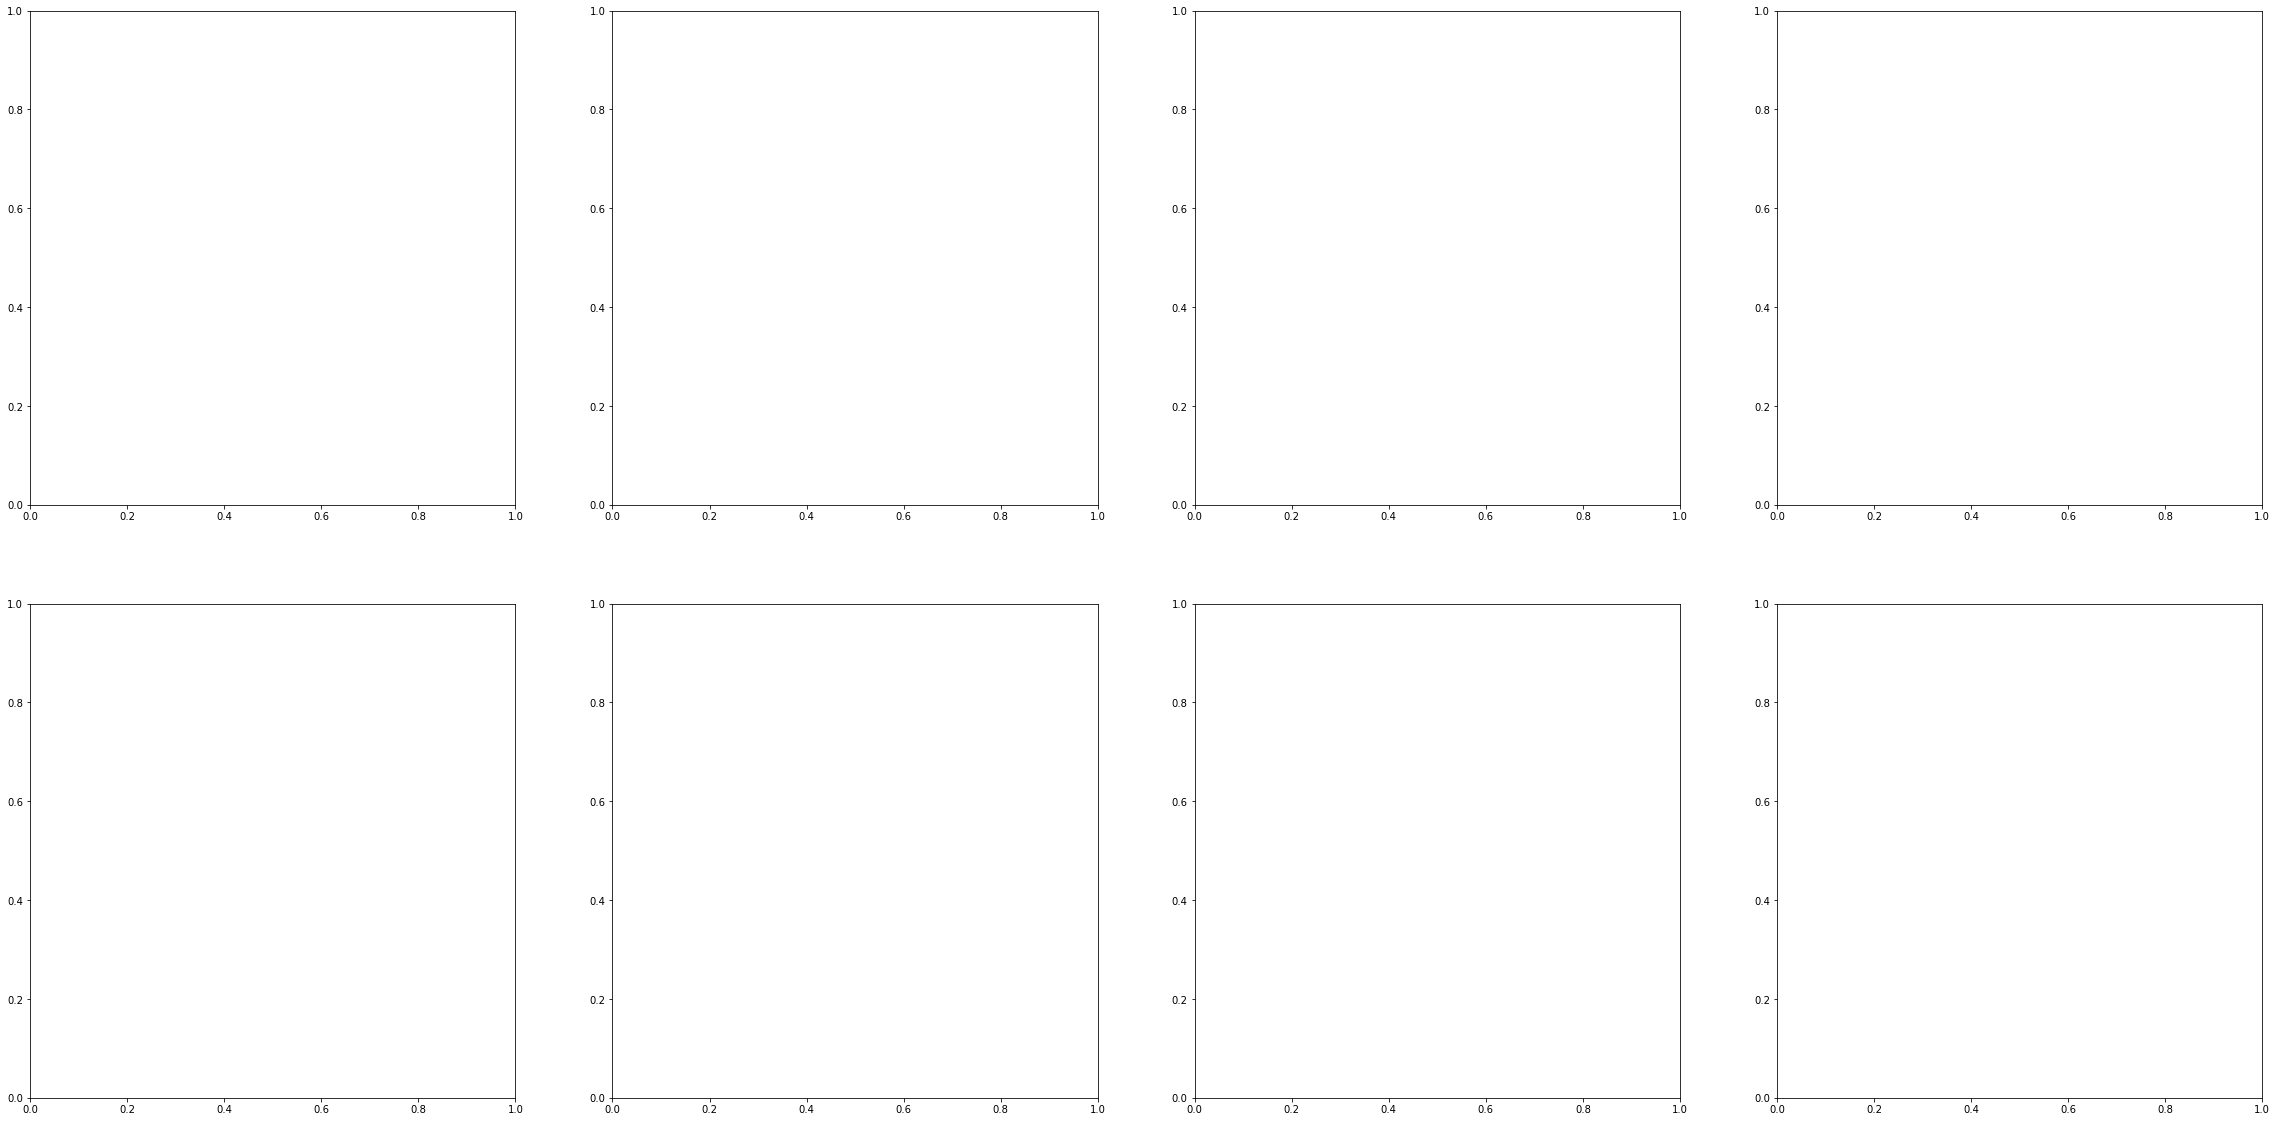

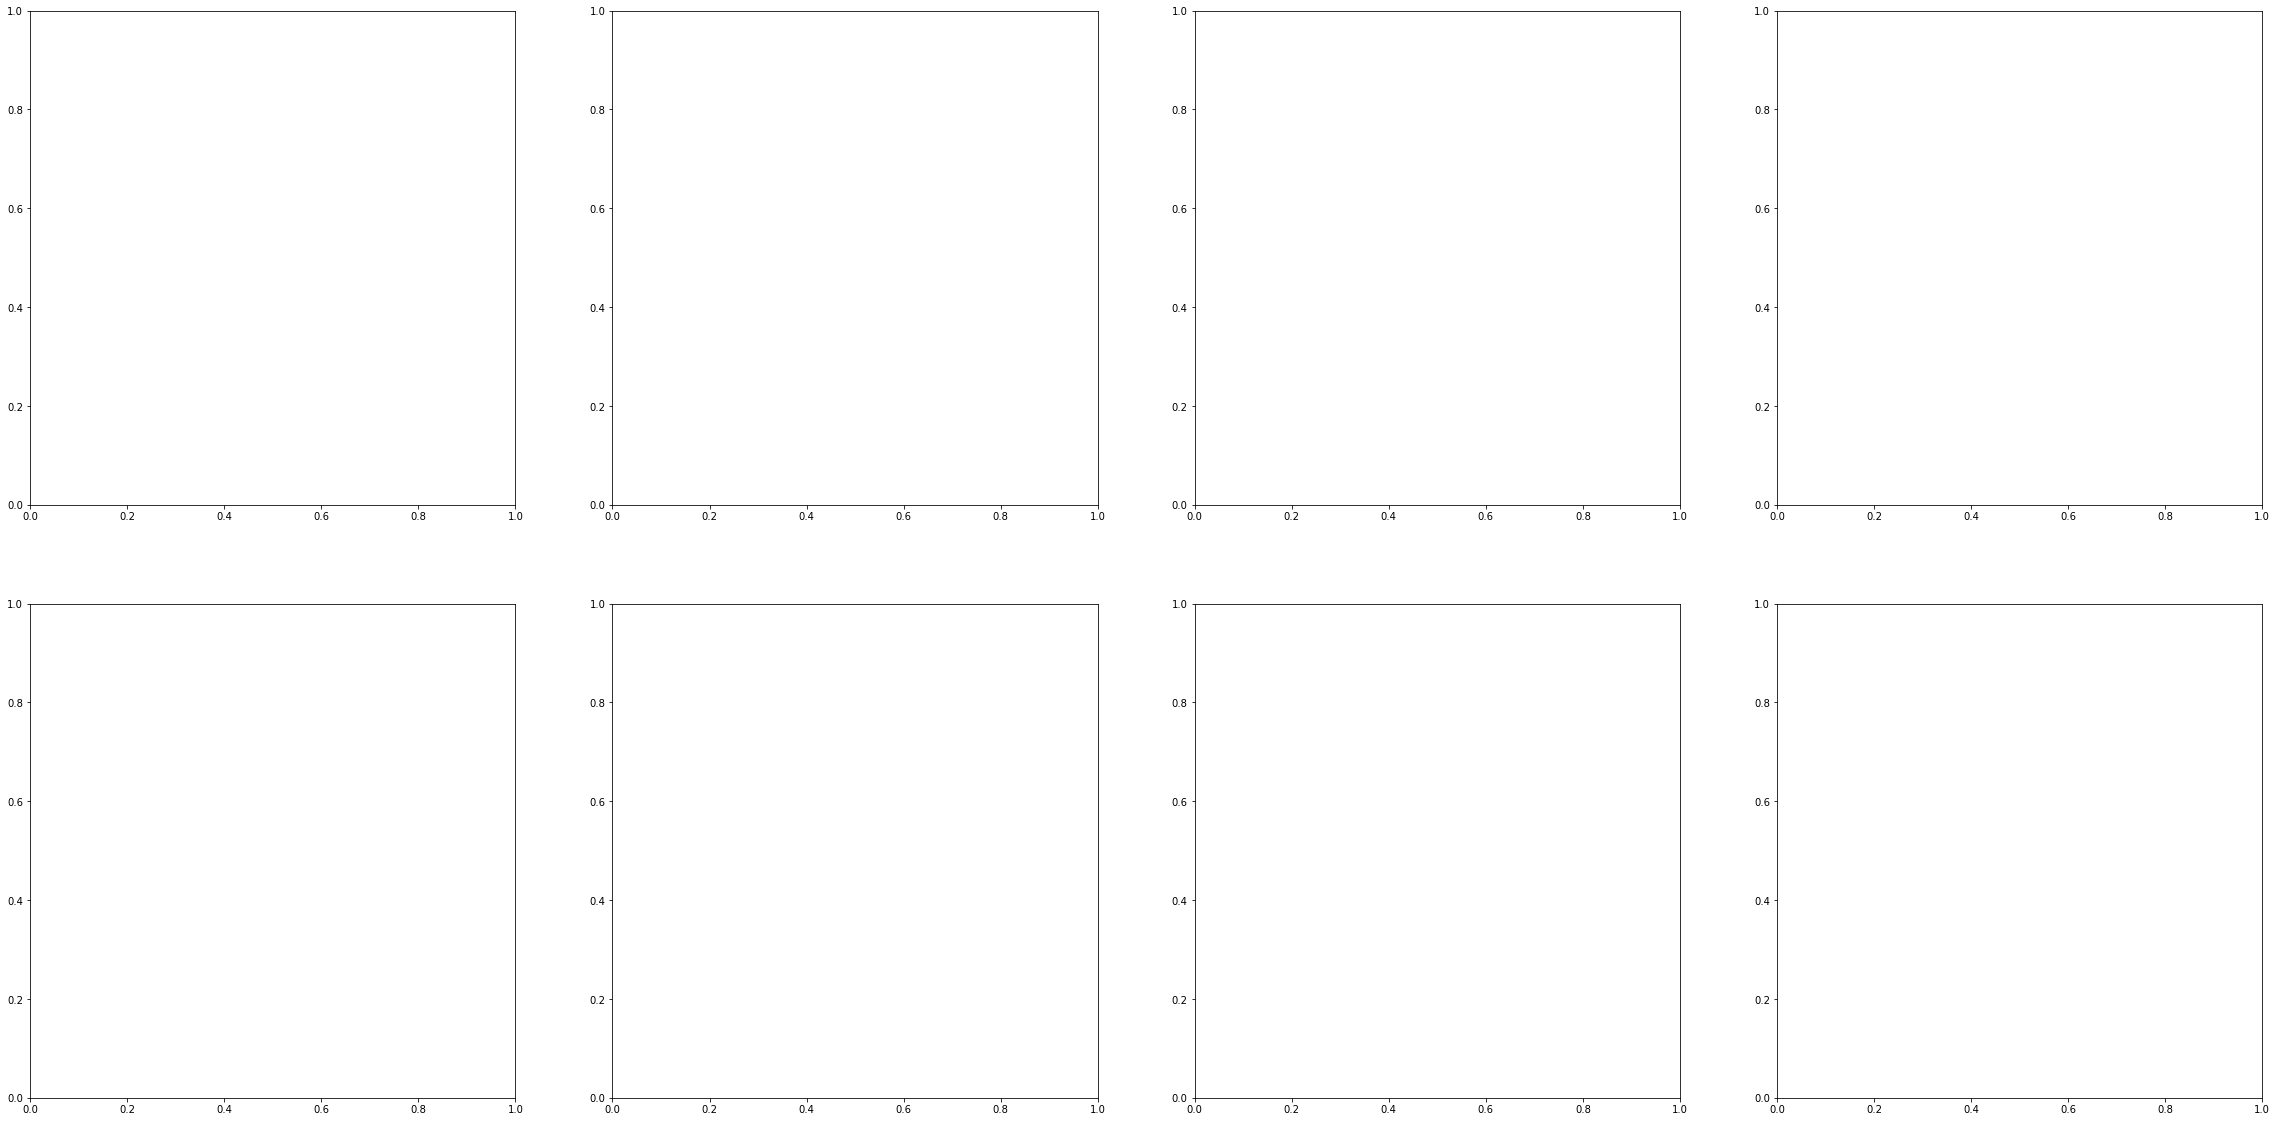

In [19]:
for find in good_freqs[::10]:
    print('Working on Frequency: ',find,freqs[find])

#     flights = Npolflights
    flightinfo=[]
    for i,flight in enumerate(Npolflights):
        flightdict={}
        flightdict['vpol'],flightdict['pols'],flightdict['cpols'],flightdict['attn'],flightdict['fi']=get_flightinfo(flight)
        flightinfo.append(flightdict)
    print(flightinfo)
    
    print(pcklarr)
    
    # beam fits
#     vpol, pols, cpols, attn, fi = get_flightinfo(fly1)
    concytest=[pcklarr[5],pcklarr[8]]
    print(concytest)
    
    gfit_directory='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
    gfitlist=[path.basename(glob.glob(gfit_directory+'*'+FLYNUM+'*.npz')[0])for FLYNUM in Npolflights]
    print(gfitlist)
    
#     concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in Npolflights]
    
    ampcorr_directory='/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
    ampcorr=[(glob.glob(ampcorr_directory+'*'+FLYNUM+'*.pkl'))[0] for FLYNUM in Npolflights]    
    print(ampcorr)
    
#    amplitude correction
#     for fly in Npolflights[1::]:
#     thingy=[]
#     amps = np.zeros([4,1024,16]) # stat [best amp value from median, median value at min, best from stdd, best from mean], freq, dish

#     apkls = glob.glob(ampdir+'*'+FLYNUM+'*.pkl')[0]
#     with open(apkls, 'rb') as inp:
#         ampdata = pickle.load(inp)
    
#     for p in pols:
#         thingy.append(np.nanmedian(ampdata[good_freqs,p],axis=0))
#     print('Flight: ',fly,' Amplitude Correction: ', np.nanmedian(thingy))
    
#     concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in flights]


#     beam1=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
#                  normalization='Gauss_wcorr',operation='coadd',mask=True,Xargs=[-1*sz,sz,1.0],
#                  Yargs=[-1*sz,sz,1.5],Fargs=[find-1,find+1,1],f_index=find)
    
#     beam=ba.Beammap_forautoprocessing(concatlist=concytest,
#                  normalization='Gauss_wcorr',gfit=True, operation='coadd',mask=True,Xargs=[-1*sz,sz,1.0],
#                  Yargs=[-1*sz,sz,1.0],Fargs=[find,find+1,1])
    
    beam=bp.Beammap(concatlist=concytest, gfitlist=gfitlist,
                 ampcorrlist=ampcorr,normalization='Gauss_wcorr',operation='coadd',Xargs=[-1*sz,sz,1.0],
                 Yargs=[-1*sz,sz,1.0],Fargs=[find,find+1,1],f_index=find)